In [1]:
# base library
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Image library
from PIL import Image

# tensorflow library
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer

# scikit-learn
from sklearn.model_selection import train_test_split

# alibi-detect
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.saving import save_detector, load_detector

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
def img_to_np(fpaths, resize=True):
    img_array = []
    for fname in fpaths:
        try:
            img = Image.open(fname).convert('RGB')
            if(resize): img = img.resize((64,64))
            img_array.append(np.asfarray(img))
        except:
            continue
    
    images = np.array(img_array)
    return images

In [4]:

img_list = glob('data//Negative//*.jpg')

# image data_load
x_train = img_to_np(img_list)
# data normalization
x_train = x_train.astype(np.float32) / 255.

# image augmentation Left, Right, Up, Down flip
x_train_lr = tf.image.flip_left_right(x_train).numpy()
x_train_ud = tf.image.flip_up_down(x_train).numpy()


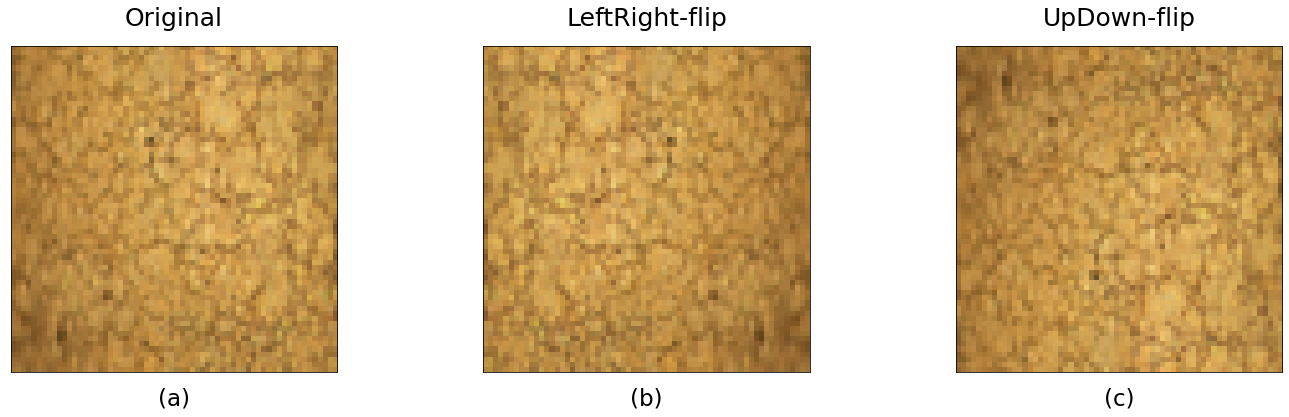

In [5]:
fig = plt.figure(figsize=(24,6))
rows = 1
cols = 3

ax1 = fig.add_subplot(rows, cols, 1)
ax2 = fig.add_subplot(rows, cols, 2)
ax3 = fig.add_subplot(rows, cols, 3)

ax1.imshow(x_train[-1])
ax1.set_title('Original', fontsize=25, pad=20)
ax1.set_xlabel('(a)', fontsize=23, labelpad=15)
ax1.set_xticks([]), ax1.set_yticks([])

ax2.imshow(x_train_lr[-1])
ax2.set_title('LeftRight-flip', fontsize=25, pad=20)
ax2.set_xlabel('(b)', fontsize=23, labelpad=15)
ax2.set_xticks([]), ax2.set_yticks([])

ax3.imshow(x_train_ud[-1])
ax3.set_title('UpDown-flip', fontsize=25, pad=20)
ax3.set_xlabel('(c)', fontsize=23, labelpad=15)
ax3.set_xticks([]), ax3.set_yticks([])

plt.show()

In [6]:
x_train = np.concatenate((x_train, x_train_lr, x_train_ud))

In [7]:
latent_dim = 1024
encoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(64, 64, 3)),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
        ])
    
decoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(latent_dim,)),
        Dense(4 * 4 * 128),
        Reshape(target_shape=(4, 4, 128)),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
        ])
    
od = OutlierVAE(threshold=.005, score_type='mse', encoder_net=encoder_net, decoder_net=decoder_net,latent_dim=latent_dim)
    
## 학습
od.fit(x_train,epochs=30,verbose=True)
    
## 저장
save_detector(od, "model_save")




938/938 [=] - 41s 42ms/step - loss_ma: -24086.7781


Directory model_save does not exist and is now created.


In [8]:
## Test 데이터 (센서 변형 후 데이터) 로드
test_img_list = glob('data//Positive_crack_sensor8_20//*.jpg')
x_test = img_to_np(test_img_list)
x_test = x_test.astype(np.float32) / 255.

## Test 데이터 아웃라이어 확인
od_preds = od.predict(x_test, outlier_type='instance', return_feature_score=True, return_instance_score=True)

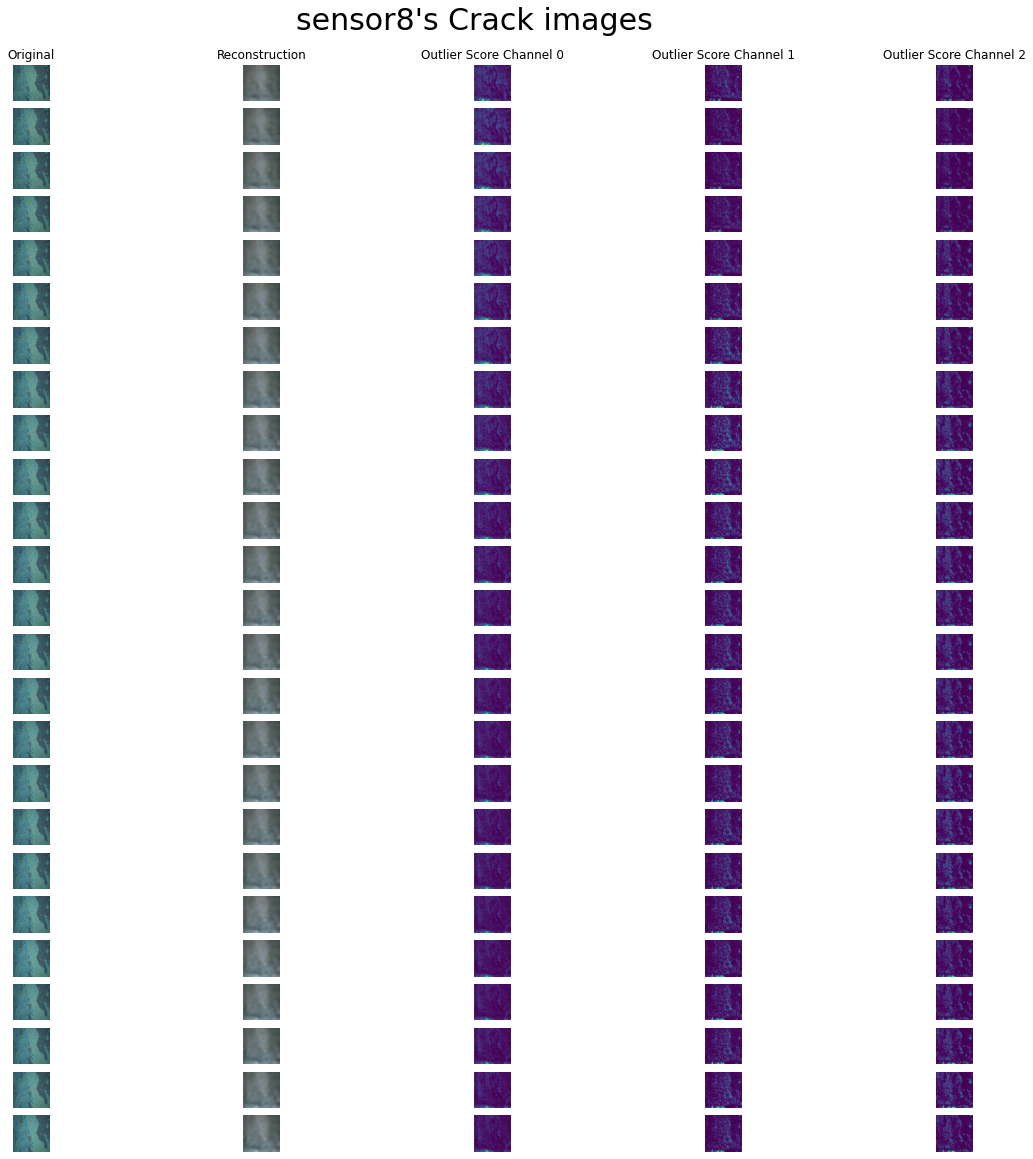

<Figure size 432x288 with 0 Axes>

In [9]:
## 결과 저장 : 1. 이미지 저장
x_recon = od.vae(x_test).numpy()
scores = od_preds['data']['feature_score']
instance_ids = list(range(len(od_preds['data']['is_outlier'])))
n_instances = min(len(test_img_list), len(instance_ids))
instance_ids = instance_ids[:n_instances]
n_cols = 5
        
mpl.rcParams['font.family'] = 'sans-serif'
fig, axes = plt.subplots(nrows=n_instances, ncols=n_cols, figsize=(20, 20))
fig.suptitle(test_img_list[0].split('_',6)[2] + "'s Crack images", size = 30, y = 0.92)

n_subplot = 1
for i in range(n_instances):
    idx = instance_ids[i]
    X_outlier = x_test[idx]
    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Original')
    plt.imshow(X_outlier)
    n_subplot += 1
    
    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Reconstruction')
    plt.imshow(x_recon[idx])
    n_subplot += 1

    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Outlier Score Channel 0')
    plt.imshow(scores[idx][:, :, 0])
    n_subplot += 1
   
    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Outlier Score Channel 1')
    plt.imshow(scores[idx][:, :, 1])
    n_subplot += 1

    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Outlier Score Channel 2')
    plt.imshow(scores[idx][:, :, 2])
    n_subplot += 1

plt.savefig(test_img_list[0].split('_',6)[2] + '_images', edgecolor='white', dpi=500, facecolor='white', transparent=True, bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.clf()

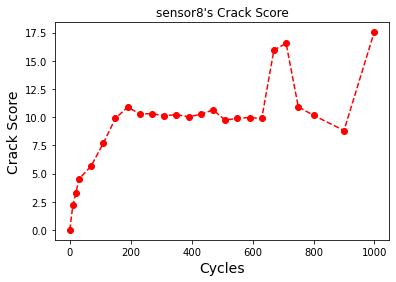

In [10]:
## 결과 저장 : 2. 그래프 저장
img_cycle = pd.DataFrame()
for i in range(len(test_img_list)):
    img_cycle = img_cycle.append([int(test_img_list[i].split('_',6)[5][0:3])])
img_cycle.rename(columns={0:"cycle"}, inplace = True)
img_cycle = img_cycle.reset_index(drop=True)

plt.plot(img_cycle['cycle'].values, (od_preds['data']['instance_score']/od_preds['data']['instance_score'][0]-1)*100, 'r--o')
plt.title(test_img_list[0].split('_',6)[2] + "'s Crack Score")
plt.xlabel("Cycles", size = 14)
plt.ylabel("Crack Score", size = 14)
plt.savefig(test_img_list[0].split('_',6)[2] +'_graph', edgecolor='white', dpi=500, facecolor='white', transparent=True, bbox_inches='tight', pad_inches=0.5)
plt.show()

## 결과 저장 : 3. 스코어 데이터 저장
out_data = pd.concat([img_cycle, pd.DataFrame(od_preds['data']['instance_score'], columns=['Crack Score']).reset_index(drop=True), pd.DataFrame(od_preds['data']['instance_score']/od_preds['data']['instance_score'][0]-1, columns=['Relative Crack Score'])*100], axis=1)
out_data.to_csv(test_img_list[0].split('_',6)[2]+"'s_crack_score_score.csv", index=False)